In [99]:
%matplotlib inline
from copy import deepcopy
from collections import OrderedDict
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD,Adam,lr_scheduler
from torch.utils.data import random_split
import torchvision
from torchvision import transforms,models
import tensorflow as tf


In [100]:
cuda_device = torch.device("cuda:0")
cpu_device = torch.device("cpu:0")

In [101]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=.40),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

traindata = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainset,valset = random_split(traindata,[42000,8000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64,shuffle=False)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=False)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
     

Files already downloaded and verified
Files already downloaded and verified


In [102]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(pretrained=True)
        self.base = nn.Sequential(*list(base.children())[:-1])
        in_features = base.fc.in_features
        self.drop = nn.Dropout()
        self.final = nn.Linear(in_features,10)
    
    def forward(self,x):
        x = self.base(x)
        x = self.drop(x.view(-1,self.final.in_features))
        return self.final(x)
    
model = Model().cuda()
[x for x,y in model.named_children()]

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['base', 'drop', 'final']

In [103]:
criterion = nn.CrossEntropyLoss()
param_groups = [
    {'params':model.base.parameters(),'lr':.0001},
    {'params':model.final.parameters(),'lr':.001}
]
optimizer = Adam(param_groups)
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
states = {}

In [104]:
%%time
best_val_acc = -1000
best_val_model = None
for epoch in range(10):  
    model.train(True)
    running_loss = 0.0
    running_acc = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.cuda(),labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() * inputs.size(0)
        out = torch.argmax(outputs.detach(),dim=1)
        assert out.shape==labels.shape
        running_acc += (labels==out).sum().item()
    print(f"Train loss {epoch+1}: {running_loss/len(trainset)},Train Acc:{running_acc*100/len(trainset)}%")
    
    correct = 0
    model.train(False)
    with torch.no_grad():
        for inputs,labels in valloader:
            out = model(inputs.cuda()).cpu()
            out = torch.argmax(out,dim=1)
            acc = (out==labels).sum().item()
            correct += acc
    print(f"Val accuracy:{correct*100/len(valset)}%")
    if correct>best_val_acc:
        best_val_acc = correct
        best_val_model = deepcopy(model.state_dict())
    lr_scheduler.step()
    
print('Finished Training') 

Train loss 1: 0.48564321865780014,Train Acc:83.26428571428572%
Val accuracy:90.925%
Train loss 2: 0.214758952328137,Train Acc:92.78095238095239%
Val accuracy:93.05%
Train loss 3: 0.18298619747445696,Train Acc:93.80952380952381%
Val accuracy:93.2%
Train loss 4: 0.18341004238242195,Train Acc:93.75952380952381%
Val accuracy:93.1875%
Train loss 5: 0.18064546084403993,Train Acc:93.87380952380953%
Val accuracy:93.125%
Train loss 6: 0.17963739491076697,Train Acc:94.11428571428571%
Val accuracy:93.3125%
Train loss 7: 0.1822021199940216,Train Acc:93.88095238095238%
Val accuracy:93.35%
Train loss 8: 0.17820448201610928,Train Acc:93.98333333333333%
Val accuracy:93.2875%
Train loss 9: 0.182564106742541,Train Acc:93.92380952380952%
Val accuracy:93.175%
Train loss 10: 0.18208228023846945,Train Acc:93.82857142857142%
Val accuracy:93.425%
Finished Training
CPU times: user 34min 13s, sys: 35.7 s, total: 34min 49s
Wall time: 34min 41s


In [108]:
model

Model(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [109]:
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = len(testset)
timings=np.zeros((repetitions,1))

In [110]:
%%time
correct = 0
model.load_state_dict(best_val_model)
model.train(False)
with torch.no_grad():
    starter.record()
    for inputs,labels in testloader:
        out = model(inputs.cuda()).cpu()
        out = torch.argmax(out,dim=1)
        acc = (out==labels).sum().item()
        correct += acc
    ender.record()
    torch.cuda.synchronize()
    curr_time = starter.elapsed_time(ender)
    timings[epoch] = curr_time
    # correct += acc
mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print(f'mean prediction latency: {mean_syn}')
print(f"Test accuracy: {correct*100/len(testset)}%")

mean prediction latency: 2.2723310546875
Test accuracy: 94.26%
CPU times: user 22.1 s, sys: 695 ms, total: 22.8 s
Wall time: 22.7 s


In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
torch.save(model.state_dict(), '/content/drive/My Drive/checkpoint.pth')

# # download checkpoint file
# files.download('checkpoint.pth')

In [61]:
import copy
state_dict = torch.load('/content/drive/My Drive/checkpoint.pth', map_location="cpu")
print(state_dict.keys())
model.load_state_dict(state_dict)
model.to(cpu_device)
# Make a copy of the model for layer fusion
fused_model = copy.deepcopy(model)

model.eval()
# The model has to be switched to evaluation mode before any layer fusion.
# Otherwise the quantization will not work correctly.
fused_model.eval()

odict_keys(['base.0.weight', 'base.1.weight', 'base.1.bias', 'base.1.running_mean', 'base.1.running_var', 'base.1.num_batches_tracked', 'base.4.0.conv1.weight', 'base.4.0.bn1.weight', 'base.4.0.bn1.bias', 'base.4.0.bn1.running_mean', 'base.4.0.bn1.running_var', 'base.4.0.bn1.num_batches_tracked', 'base.4.0.conv2.weight', 'base.4.0.bn2.weight', 'base.4.0.bn2.bias', 'base.4.0.bn2.running_mean', 'base.4.0.bn2.running_var', 'base.4.0.bn2.num_batches_tracked', 'base.4.1.conv1.weight', 'base.4.1.bn1.weight', 'base.4.1.bn1.bias', 'base.4.1.bn1.running_mean', 'base.4.1.bn1.running_var', 'base.4.1.bn1.num_batches_tracked', 'base.4.1.conv2.weight', 'base.4.1.bn2.weight', 'base.4.1.bn2.bias', 'base.4.1.bn2.running_mean', 'base.4.1.bn2.running_var', 'base.4.1.bn2.num_batches_tracked', 'base.5.0.conv1.weight', 'base.5.0.bn1.weight', 'base.5.0.bn1.bias', 'base.5.0.bn1.running_mean', 'base.5.0.bn1.running_var', 'base.5.0.bn1.num_batches_tracked', 'base.5.0.conv2.weight', 'base.5.0.bn2.weight', 'base.

Model(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

QUANTIZATION

In [62]:
# # create a model instance
# model_fp32 = M()
# create a quantized model instance
model_int8 = torch.quantization.quantize_dynamic(
    model,  # the original model
    {torch.nn.Sequential, torch.nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)  # the target dtype for quantized weights
model_int8.to(cpu_device)

Model(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [63]:
trainloader.__len__()

657

In [64]:
len(trainset)

42000

In [67]:
%%time
import matplotlib.pyplot as plt
batches=20
number_of_training_data=len(trainset)/trainloader.__len__()*batches
loss_lst=[]
accuracy_lst=[]
best_val_acc = -1000
best_val_model = None
for epoch in range(15):
    model_int8.train(True)
    running_loss = 0.0
    running_acc = 0
    for i, data in enumerate(trainloader, 0):
        if i ==batches: break
        inputs, labels = data
                  
        outputs = model_int8(inputs)
        optimizer.zero_grad()
        outputs = model_int8(inputs)
        loss = criterion(outputs, labels)
        # loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() * inputs.size(0)
        out = torch.argmax(outputs.detach(),dim=1)
        assert out.shape==labels.shape
        running_acc += (labels==out).sum().item()
    accuracy_lst.append(running_acc*100/number_of_training_data)
    loss_lst.append(running_loss/number_of_training_data)
    print(f"Train loss {epoch+1}: {running_loss/number_of_training_data},Train Acc:{running_acc*100/number_of_training_data}%")

Train loss 1: 0.21022539262941908,Train Acc:92.76214285714286%
Train loss 2: 0.21531218139103483,Train Acc:92.21464285714286%
Train loss 3: 0.2282260157959802,Train Acc:92.76214285714286%
Train loss 4: 0.2204372476203101,Train Acc:91.4325%
Train loss 5: 0.19457123682158337,Train Acc:93.54428571428572%
Train loss 6: 0.22754813356569836,Train Acc:92.5275%
Train loss 7: 0.21026848345143456,Train Acc:92.91857142857144%
Train loss 8: 0.1723701254418918,Train Acc:94.48285714285716%
Train loss 9: 0.18257191587516242,Train Acc:93.85714285714286%
Train loss 10: 0.1969886946303504,Train Acc:93.7007142857143%
Train loss 11: 0.2055361240574292,Train Acc:92.68392857142858%
Train loss 12: 0.18056402637362481,Train Acc:94.2482142857143%
Train loss 13: 0.19091728660890037,Train Acc:93.30964285714286%
Train loss 14: 0.17783451040302006,Train Acc:94.17%
Train loss 15: 0.20075232002735138,Train Acc:93.1532142857143%
CPU times: user 43min 53s, sys: 1min 22s, total: 45min 16s
Wall time: 45min 5s


In [68]:
accuracy_lst

[92.76214285714286,
 92.21464285714286,
 92.76214285714286,
 91.4325,
 93.54428571428572,
 92.5275,
 92.91857142857144,
 94.48285714285716,
 93.85714285714286,
 93.7007142857143,
 92.68392857142858,
 94.2482142857143,
 93.30964285714286,
 94.17,
 93.1532142857143]

In [69]:
loss_lst

[0.21022539262941908,
 0.21531218139103483,
 0.2282260157959802,
 0.2204372476203101,
 0.19457123682158337,
 0.22754813356569836,
 0.21026848345143456,
 0.1723701254418918,
 0.18257191587516242,
 0.1969886946303504,
 0.2055361240574292,
 0.18056402637362481,
 0.19091728660890037,
 0.17783451040302006,
 0.20075232002735138]

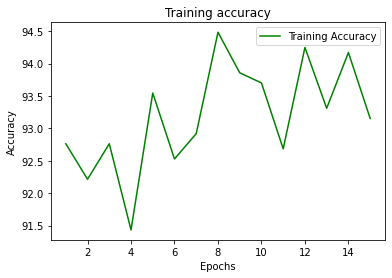

In [71]:
import matplotlib.pyplot as plt
epoch_lst=range(1,16)
plt.plot(epoch_lst, accuracy_lst, 'g', label='Training Accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

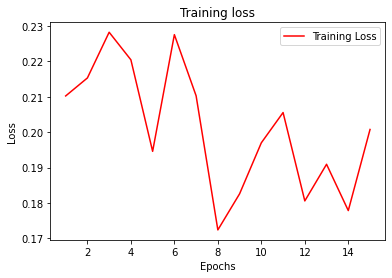

In [74]:
import matplotlib.pyplot as plt
epoch_lst=range(1,16)
plt.plot(epoch_lst, loss_lst, 'r', label='Training Loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [80]:
testloader.__len__()

157

In [81]:
len(testset)

10000

In [90]:
%%time
batches=100
number_of_testing_data=(len(testset)/testloader.__len__())*batches
correct = 0
# model.load_state_dict(best_val_model)
model_int8.train(False)
i=0
with torch.no_grad():
    for inputs,labels in testloader:
        if i ==batches: break
        out = model_int8(inputs).cpu()
        out = torch.argmax(out,dim=1)
        acc = (out==labels).sum().item()
        correct += acc
        i+=1
print(f"Test accuracy: {correct*100/number_of_testing_data}%")

Test accuracy: 94.6239%
CPU times: user 6min 28s, sys: 3.64 s, total: 6min 32s
Wall time: 6min 31s


In [91]:
model_int8

Model(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [92]:
import os
size=os.path.getsize("/content/drive/My Drive/checkpoint.pth")
size

44804621

In [93]:
import os
torch.save(model_int8.state_dict(), '/content/drive/My Drive/checkpoint_int8.pth')
size_int8=os.path.getsize("/content/drive/My Drive/checkpoint_int8.pth")
size_int8

44788361

In [94]:
state_dict = torch.load('/content/drive/My Drive/checkpoint.pth')
print(state_dict.keys())

odict_keys(['base.0.weight', 'base.1.weight', 'base.1.bias', 'base.1.running_mean', 'base.1.running_var', 'base.1.num_batches_tracked', 'base.4.0.conv1.weight', 'base.4.0.bn1.weight', 'base.4.0.bn1.bias', 'base.4.0.bn1.running_mean', 'base.4.0.bn1.running_var', 'base.4.0.bn1.num_batches_tracked', 'base.4.0.conv2.weight', 'base.4.0.bn2.weight', 'base.4.0.bn2.bias', 'base.4.0.bn2.running_mean', 'base.4.0.bn2.running_var', 'base.4.0.bn2.num_batches_tracked', 'base.4.1.conv1.weight', 'base.4.1.bn1.weight', 'base.4.1.bn1.bias', 'base.4.1.bn1.running_mean', 'base.4.1.bn1.running_var', 'base.4.1.bn1.num_batches_tracked', 'base.4.1.conv2.weight', 'base.4.1.bn2.weight', 'base.4.1.bn2.bias', 'base.4.1.bn2.running_mean', 'base.4.1.bn2.running_var', 'base.4.1.bn2.num_batches_tracked', 'base.5.0.conv1.weight', 'base.5.0.bn1.weight', 'base.5.0.bn1.bias', 'base.5.0.bn1.running_mean', 'base.5.0.bn1.running_var', 'base.5.0.bn1.num_batches_tracked', 'base.5.0.conv2.weight', 'base.5.0.bn2.weight', 'base.

In [95]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [96]:
print(state_dict)

OrderedDict([('base.0.weight', tensor([[[[-1.0136e-02, -6.6520e-03, -2.5220e-03,  ...,  5.6144e-02,
            1.6782e-02, -1.2713e-02],
          [ 1.1673e-02,  8.8718e-03, -1.1071e-01,  ..., -2.7176e-01,
           -1.2931e-01,  3.8805e-03],
          [-6.4202e-03,  5.8682e-02,  2.9507e-01,  ...,  5.1944e-01,
            2.5605e-01,  6.3321e-02],
          ...,
          [-2.7165e-02,  1.5640e-02,  7.2441e-02,  ..., -3.3296e-01,
           -4.2058e-01, -2.5777e-01],
          [ 3.0950e-02,  4.0570e-02,  6.2740e-02,  ...,  4.1406e-01,
            3.9360e-01,  1.6619e-01],
          [-1.3243e-02, -3.8587e-03, -2.3939e-02,  ..., -1.5018e-01,
           -8.1792e-02, -5.1704e-03]],

         [[-1.1637e-02, -2.7824e-02, -3.5924e-02,  ...,  3.1720e-02,
            1.4878e-04, -2.5923e-02],
          [ 4.5625e-02,  3.2130e-02, -1.0602e-01,  ..., -3.1337e-01,
           -1.6084e-01, -1.0549e-03],
          [-9.5712e-04,  9.7235e-02,  4.0101e-01,  ...,  7.0725e-01,
            3.6849e-01,  1.